# Week 3 Final Exercise: Twitter Sentiment Analysis

https://www.kaggle.com/kazanova/sentiment140

Context

This is the sentiment140 dataset. It contains **1,600,000** tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .
Content

It contains the following 6 fields:

    0 target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)  <-- use this

    1 ids: The id of the tweet (1467810672)

    2 date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

    3 flag: The query (lyx). If there is no query, then this value is NO_QUERY.

    4 user: the user that tweeted (robotickilldozr)

    5 text: the text of the tweet (Lyx is cool) <--- use this

In [1]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [2]:
embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 160000 # Only use 10% for training/testing in this project
test_portion=.1

In [3]:
# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

import os
import wget

url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv'
out = f'{os.getcwd()}\\twitter_training_cleaned.csv'

if not os.path.isfile(out):
    wget.download(url, out=out)

# The corpus contains all samples (1.6 million), but only sentences and labels.

In [4]:
num_sentences = 0
corpus = []

with open(f'{os.getcwd()}\\twitter_training_cleaned.csv', encoding='utf8', errors='ignore') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
      # Your Code here. Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
      # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
        list_item = []
        # label
        list_item.append(row[5])
        this_label = row[0] # YOUR CODE HERE
        if this_label == '0':
            list_item.append(0)
        else:
            list_item.append(1) # convert 4 to 1
        # sentence
        num_sentences = num_sentences + 1
        corpus.append(list_item)

print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


# Separate Corpus into Sentences and Labels vars

In [5]:
sentences = []
labels = []
random.shuffle(corpus)

for x in range(training_size):
    sentences.append(corpus[x][0]) # YOUR CODE HERE
    labels.append(corpus[x][1]) # YOUR CODE HERE

print(sentences[10])
print(labels[10])

@tshogan63 oh go on and hush!  stinker!  I thought I heard a couple grunts coming from your end of the line too!  
1


# 1 Create Sequences, 2 Pad, 3 Split Sentences and Labels into Train and Test

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences) # YOUR CODE HERE

word_index = tokenizer.word_index
vocab_size = len(word_index) # YOUR CODE HERE

# 1 Create Sequences
sequences = tokenizer.texts_to_sequences(sentences) # YOUR CODE HERE

# 2 Pad
padded = pad_sequences(sequences) # YOUR CODE HERE

# Split
split = int(test_portion * training_size)

test_sequences = padded[0:split] # YOUR CODE HERE
training_sequences = padded[split:training_size] # YOUR CODE HERE

test_labels = labels[0:split] # YOUR CODE HERE
training_labels = labels[split:training_size] # YOUR CODE HERE

# convert all to numpy
training_sequences = np.array(training_sequences)
training_labels = np.array(training_labels)
test_sequences = np.array(test_sequences)
test_labels = np.array(test_labels)

print("Vocabulary size: ",vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

Vocabulary size:  138832
1


## Transfer Learning loading

In [7]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier

url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt'
out = f'{os.getcwd()}\\glove.6B.100d.txt'

if not os.path.isfile(out):
    wget.download(url, out=out)

In [8]:
embeddings_index = {};
with open(f'{os.getcwd()}\\glove.6B.100d.txt', encoding='utf8', errors='ignore') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;
        
print("Length Embeddings_matrix: ",len(embeddings_matrix))
# Expected Output
# 138859

Length Embeddings_matrix:  138833


In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False), ### here we load up the embedding_matrix from Stanford
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid') # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy']) # YOUR CODE HERE
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           13883300  
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 13,948,453
Trainable params: 65,153
Non-trainable params: 13,883,300
_______________________________________

In [10]:
num_epochs = 50
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=2)

print("Training Complete")

Epoch 1/50
4500/4500 - 22s - loss: 0.5480 - accuracy: 0.7182 - val_loss: 0.5013 - val_accuracy: 0.7514
Epoch 2/50
4500/4500 - 21s - loss: 0.5046 - accuracy: 0.7512 - val_loss: 0.4841 - val_accuracy: 0.7649
Epoch 3/50
4500/4500 - 21s - loss: 0.4868 - accuracy: 0.7627 - val_loss: 0.4771 - val_accuracy: 0.7673
Epoch 4/50
4500/4500 - 23s - loss: 0.4755 - accuracy: 0.7692 - val_loss: 0.4721 - val_accuracy: 0.7731
Epoch 5/50
4500/4500 - 23s - loss: 0.4656 - accuracy: 0.7760 - val_loss: 0.4750 - val_accuracy: 0.7703
Epoch 6/50
4500/4500 - 23s - loss: 0.4596 - accuracy: 0.7787 - val_loss: 0.4747 - val_accuracy: 0.7741
Epoch 7/50
4500/4500 - 24s - loss: 0.4532 - accuracy: 0.7832 - val_loss: 0.4682 - val_accuracy: 0.7734
Epoch 8/50
4500/4500 - 22s - loss: 0.4487 - accuracy: 0.7856 - val_loss: 0.4660 - val_accuracy: 0.7754
Epoch 9/50
4500/4500 - 21s - loss: 0.4433 - accuracy: 0.7898 - val_loss: 0.4687 - val_accuracy: 0.7713
Epoch 10/50
4500/4500 - 21s - loss: 0.4400 - accuracy: 0.7907 - val_loss:

<Figure size 432x288 with 0 Axes>

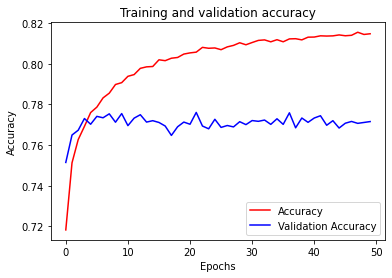

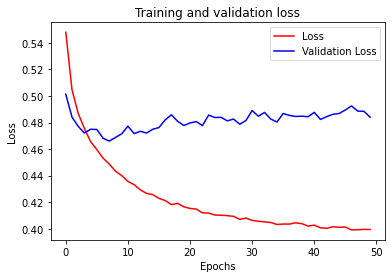

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!